# Bayesian Inference with Multivariate Exponential Distributions
We define the *multivariate exponential distributions* $(\text{Exp}(\tau,\Pi))_{\tau, \Pi}$ as a sub-class of the symmetric generalized multivariate normal distributions by specifying that, for any $\tau \in \mathbb{R}^d$ and positive definite $\Pi \in \mathbb{R}^{d \times d}$, the distribution $\text{Exp}(\tau,\Pi)$ must have (unnormalized) density
$$ \text{Exp}(x; \tau,\Pi) := \exp\!\big(- \big((x - \tau)^T \Pi^{-1} (x - \tau) \big)^{1/2}\big)
, \qquad x \in \mathbb{R}^d .$$
We note that for any $\tau \in \mathbb{R}^d$ and $\sigma^2 > 0$ one has
$$ \text{Exp}(x; \tau,\sigma^2 I_d) = \exp(-\Vert x - \tau \Vert / \sigma)
, \qquad x \in \mathbb{R}^d .$$

For the experiment, we want to target a posterior distribution composed of multivariate exponential distributions. Suppose that there is a $d$-dimensional random vector of interest $X$. We impose the standard multivariate exponential prior $X \sim \text{Exp}(\mathbf{0},I_d)$. Furthermore, we presume to have access to a spectrum of different ways of measuring $X$ up to additive noise, and that these ways differ in the type of noise incurred, with there being advantages and disadvantages to each end: On one end of the spectrum, the different components of the noise vector are very strongly correlated but their variance is large. On the other end they have small variance but are far closer to independence. Specifically, the different measurement options are modeled by a sequence of random vectors $(Z_m)_{m \in \mathbb{N}}$ given by
$$ Z_m = X + \varepsilon_m , 
\quad \varepsilon_m \sim \text{Exp}(\mathbf{0},\Pi^{(m)}) ,
\quad \Pi^{(m)}_{i,j} = \begin{cases} (m+1)^2 / d & i = j , \\ m(m+1) / d & i \neq j . \end{cases} $$
To obtain a concrete likelihood, we "secretly" sample a "true value" for $X$ from $\mathcal{N}_d(\mathbf{0}, d \cdot I_d) \approx \text{Exp}(\mathbf{0},I_d)$ and use it to generate independent synthetic data $z_1,...,z_{100} \in \mathbb{R}^d$, representing one realization each of the vectors $Z_1,...,Z_{100}$ (although for simplicity we only generate the data from an approximation of the above model). To summarize, our target density in this experiment is the (unnormalized) posterior density
$$ \varrho(x) 
= \text{Exp}(x; \mathbf{0},I_d) \prod_{m=1}^{100} \text{Exp}(z_m; x,\Pi^{(m)})
= \exp\!\bigg( -\Vert x \Vert - \sum_{m=1}^{100} \big( (x - z_m)^T (\Pi^{(m)})^{-1} (x - z_m) \big)^{1/2} \bigg) ,
\quad x \in \mathbb{R}^d .$$

In [1]:
from patt_mcmc import patt_ess, patt_gpss
from hit_and_run_uniform_slice_sampling import parallel_hruss
from random_walk_metropolis import parallel_ada_rwm
from generalized_elliptical_slice_sampling import two_group_gess
import stan_utils as su
import mcmc_utils as mcu
import plotting_functions as pfs

In [2]:
import numpy as np
import numpy.linalg as alg
import numpy.random as rnd
import pandas as pd
import time as tm
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
path_prefix = "../plots/Bayesian_inf_multiv_exp_distr_"

### Construct Target Density

In [4]:
d = 50 # sample space dimension (high dims work in principle but the target density evaluation becomes quite slow)

In [5]:
## prepare a likelihood (by generating synthetic data from a true parameter and an approximation of the model)
x_true = rnd.normal(scale=np.sqrt(d), size=d)
m_max = 100
Sigmas = np.array([(np.full((d,d), m*(m+1)/d) + (m+1)/d * np.identity(d)) for m in range(1,m_max+1)])
Sigma_invs = np.array([alg.inv(Sigma) for Sigma in Sigmas])
data = np.zeros((m_max,d))
for m in range(m_max):
    data[m] = np.sqrt(d) * rnd.multivariate_normal(x_true, Sigmas[m])
del x_true

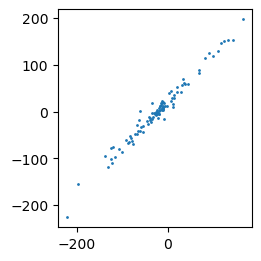

In [6]:
pfs.plot_samples(data[:,:2], (2.5,2.5))

In [7]:
def log_density(x):
    log_prior = - alg.norm(x)
    log_lik = - np.sum(np.sum((x-data) * (Sigma_invs @ (x-data).reshape(m_max,d,1)).reshape(m_max,d),axis=1)**(1/2))
    return log_prior + log_lik

In [8]:
if d == 2:
    density = lambda x: np.exp(log_density(x))
    ext = 5
    data_mean = np.mean(data, axis=0)
    G1, G2, vals = pfs.contour_precalc(250,data_mean[0]-ext,data_mean[0]+ext,data_mean[1]-ext,data_mean[1]+ext,density)
    plt.figure(figsize=(3,3))
    plt.contourf(G1, G2, vals)
    plt.show()

#### Special Treatment for Stan

In [9]:
stan_code = """
data {
    int m_max;
    int d;
    array[m_max] vector[d] z;
    array[m_max] matrix[d,d] Sigma_inv;
}
parameters {
    vector[d] x;
}
model {
    // prior:
    target += -sqrt(dot_self(x));
    // likelihood:
    for(m in 1:m_max){
        target += -sqrt(quad_form(Sigma_inv[m], x - z[m]));
    }
}
"""

In [10]:
stan_data = {
    'm_max': m_max,
    'd': d,
    'z': data,
    'Sigma_inv': Sigma_invs,
}

In [11]:
su.prevent_crashes(stan_code, stan_data)

Building: found in cache, done.
Sampling:   0%
Sampling: 100% (1/1)
Sampling: 100% (1/1), done.
Messages received during sampling:
  Gradient evaluation took 0.00087 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.7 seconds.
  Adjust your expectations accordingly!
           performed for num_warmup < 20


### Run the Samplers
In running the samplers, we try to allocate each of them roughly the same computational budget. Regardless of how many iterations a sampler performs and how many parallel chains it uses, we ultimately judge it solely by its performance in the latter half of all of its chains.

Note: If either PATT-GPSS or GESS is run before HRUSS and AdaRWM, it breaks the latter's progress bars, likely due to some sort of incompatibility between tqdm.tqdm and tqdm.notebook.tqdm.

In [12]:
n_chains = 10 # number of parallel chains permitted to each sampler (except GESS)
n_its = int(1e5) # total number of iterations per chain, per sampler (except AdaRWM, GESS)
x_0s = np.mean(data, axis=0) + rnd.normal(size=(n_chains,d)) # suggested initial states

#### Hit-and-run Uniform Slice Sampling

In [13]:
w_hruss = 1.0

In [14]:
samples_hruss, tde_hruss, times_hruss = parallel_hruss(log_density, n_chains, n_its, x_0s, w_hruss)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|██████████████████████████████████| 100000/100000 [02:01<00:00, 819.85it/s]


Processing returns and terminating...


#### Adaptive Random Walk Metropolis
Note: We grant AdaRWM significantly more iterations than its competitors because it has a much lower computational cost per iteration (by virtue of only using one TDE per iteration) and we intend to grant the different samplers roughly the same computational budget.

In [15]:
n_its_rwm = 5 * n_its

In [16]:
samples_rwm, times_rwm, ldv_rwm, means_rwm, cov_rwm = parallel_ada_rwm(log_density, n_chains, n_its_rwm, x_0s)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|█████████████████████████████████| 500000/500000 [03:10<00:00, 2618.66it/s]


Processing returns and terminating...


In [17]:
tde_rwm = np.ones((n_its_rwm+1,n_chains), dtype=int)

In [18]:
# to conserve memory, we already summarize and then delete the means of RWM at this point
norms_rwm = mcu.get_radii(means_rwm)
del means_rwm

#### PATT Elliptical Slice Sampling

In [19]:
n_burn_ess = n_its // 10
n_its_ess = n_its - n_burn_ess

In [20]:
ret_dic = patt_ess(
    log_density,
    n_chains,
    n_burn_ess,
    n_its_ess,
    x_0s,
    cen_mode='mean',
    cov_mode='cov',
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/90001 [00:00<?, ?it/s]

Assembling output...


In [21]:
samples_ess = np.vstack([ret_dic['burn-in'], ret_dic['samples'][1:]])
tde_ess = np.vstack([ret_dic['tde_cnts_burn'], ret_dic['tde_cnts'][1:]])
times_ess = np.vstack([ret_dic['runtimes_burn'], ret_dic['runtimes'][1:]])
means_ess = ret_dic['means']
covs_ess = ret_dic['covs']
schedule_ess = ret_dic['schedule']

#### PATT Gibbsian Polar Slice Sampling

In [22]:
n_burn_gpss = n_its // 10
n_its_gpss = n_its - n_burn_gpss
w_burn = d
w_att = np.sqrt(d)

In [23]:
ret_dic = patt_gpss(
    log_density,
    n_chains,
    n_burn_gpss,
    n_its_gpss,
    x_0s,
    cen_mode='mean',
    cov_mode='cov',
    w_burn=w_burn,
    w_att=w_att,
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/90001 [00:00<?, ?it/s]

Assembling output...


In [24]:
samples_gpss = np.vstack([ret_dic['burn-in'], ret_dic['samples'][1:]])
tde_gpss = np.vstack([ret_dic['tde_cnts_burn'], ret_dic['tde_cnts'][1:]])
times_gpss = np.vstack([ret_dic['runtimes_burn'], ret_dic['runtimes'][1:]])
means_gpss = ret_dic['means']
covs_gpss = ret_dic['covs']
schedule_gpss = ret_dic['schedule']

#### Two-Group Generalized Elliptical Slice Sampling
Note: We grant GESS significantly more iterations than is appropriate with regards to our intent to allocate each method roughly the same computational budget. This is necessitated by GESS's demand for a very large number of chains on the one hand, and our desire to properly analyze the autocorrelation of each of these chains on the other hand.

In [25]:
n_chains_gess = max(2*d, n_chains)
n_its_gess = int(2e4)
x_0s_gess = np.mean(data, axis=0) + rnd.normal(size=(2*n_chains_gess,d))

In [26]:
time_b = tm.time()
ret_dic = two_group_gess(log_density, n_chains_gess, 2 * n_its_gess, x_0s_gess, n_thr=n_chains)
time_a = tm.time()
total_time_gess = time_a - time_b

Checking validity of given arguments...
Preparing for parallel sampling...
Starting two-group sampling...


  0%|          | 0/40002 [00:00<?, ?it/s]

Assembling output...


In [27]:
samples_gess = ret_dic['samples']
tde_gess = ret_dic['tde_cnts']
schedule_gess = ret_dic['schedule']
dfs_G1, dfs_G2 = ret_dic['dfs']
centers_G1, centers_G2 = ret_dic['centers']
centers_gess = np.concatenate([centers_G1.reshape(-1,1,d), centers_G2.reshape(-1,1,d)], axis=1)
scale_G1, scale_G2 = ret_dic['scales']

#### Stan's NUTS

In [28]:
n_its_stan = n_its // 10

In [29]:
time_b = tm.time()
frames_stan, samples_stan, tge_stan, acc_rates_stan \
= su.sample_in_parallel(stan_code, stan_data, n_chains, n_its_stan, x_0s)
time_a = tm.time()
total_time_stan = time_a - time_b

Building: 0.3s
Building: 0.2s


Building: found in cache, done.


Building: 0.7s


Building: found in cache, done.
Building: found in cache, done.


Building: 0.5s


Building: found in cache, done.
Building: found in cache, done.


Building: found in cache, done.
Building: found in cache, done.
Building: found in cache, done.
Building: found in cache, done.
Building: found in cache, done.
Sampling:   0%
Sampling:   0%
Sampling:   0%
Sampling:   0%
Sampling:   0%
Sampling:   0%
Sampling:   0%
Sampling:   0%
Sampling:   0%
Sampling:   0%
Sampling:   0% (1/11000)
Sampling:   2% (200/11000)
Sampling:   0% (1/11000)
Sampling:   0% (1/11000)
Sampling:   0% (1/11000)
Sampling:   0% (1/11000)
Sampling:   0% (1/11000)
Sampling:   0% (1/11000)
Sampling:   0% (1/11000)
Sampling:   0% (1/11000)
Sampling:   0% (1/11000)
Sampling:   3% (300/11000)
Sampling:   1% (100/11000)
Sampling:   1% (100/11000)
Sampling:   1% (100/11000)
Sampling:   1% (100/11000)
Sampling:   1% (100/11000)
Sampling:   1% (100/11000)
Sampling:   1% (100/11000)
Sampling:   1% (100/11000)
Sampling:   1% (100/11000)
Sampling:   4% (400/11000)
Sampling:   2% (200/11000)
Sampling:   2% (200/11000)
Sampling:   2% (200/11000)
Sampling:   5% (500/11000)
Sampling

Sampling:  15% (1600/11000)
Sampling:  15% (1700/11000)
Sampling:  15% (1600/11000)
Sampling:  15% (1700/11000)
Sampling:  15% (1700/11000)
Sampling:  15% (1700/11000)
Sampling:  15% (1700/11000)
Sampling:  19% (2100/11000)
Sampling:  15% (1700/11000)
Sampling:  16% (1800/11000)
Sampling:  15% (1700/11000)
Sampling:  16% (1800/11000)
Sampling:  15% (1700/11000)
Sampling:  16% (1800/11000)
Sampling:  16% (1800/11000)
Sampling:  16% (1800/11000)
Sampling:  16% (1800/11000)
Sampling:  16% (1800/11000)
Sampling:  20% (2200/11000)
Sampling:  17% (1900/11000)
Sampling:  16% (1800/11000)
Sampling:  16% (1800/11000)
Sampling:  17% (1900/11000)
Sampling:  17% (1900/11000)
Sampling:  17% (1900/11000)
Sampling:  17% (1900/11000)
Sampling:  17% (1900/11000)
Sampling:  21% (2300/11000)
Sampling:  17% (1900/11000)
Sampling:  18% (2000/11000)
Sampling:  17% (1900/11000)
Sampling:  18% (2000/11000)
Sampling:  17% (1900/11000)
Sampling:  18% (2000/11000)
Sampling:  18% (2000/11000)
Sampling:  18% (2000

Sampling:  48% (5300/11000)
Sampling:  49% (5400/11000)
Sampling:  50% (5500/11000)
Sampling:  47% (5200/11000)
Sampling:  48% (5300/11000)
Sampling:  48% (5300/11000)
Sampling:  48% (5300/11000)
Sampling:  48% (5300/11000)
Sampling:  48% (5300/11000)
Sampling:  53% (5800/11000)
Sampling:  49% (5400/11000)
Sampling:  50% (5500/11000)
Sampling:  51% (5600/11000)
Sampling:  48% (5300/11000)
Sampling:  49% (5400/11000)
Sampling:  49% (5400/11000)
Sampling:  49% (5400/11000)
Sampling:  49% (5400/11000)
Sampling:  49% (5400/11000)
Sampling:  50% (5500/11000)
Sampling:  54% (5900/11000)
Sampling:  51% (5600/11000)
Sampling:  52% (5700/11000)
Sampling:  49% (5400/11000)
Sampling:  50% (5500/11000)
Sampling:  50% (5500/11000)
Sampling:  50% (5500/11000)
Sampling:  50% (5500/11000)
Sampling:  50% (5500/11000)
Sampling:  52% (5700/11000)
Sampling:  51% (5600/11000)
Sampling:  55% (6000/11000)
Sampling:  53% (5800/11000)
Sampling:  51% (5600/11000)
Sampling:  50% (5500/11000)
Sampling:  51% (5600

Sampling:  81% (8900/11000)
Sampling:  81% (8900/11000)
Sampling:  85% (9300/11000)
Sampling:  81% (8900/11000)
Sampling:  85% (9400/11000)
Sampling:  80% (8800/11000)
Sampling:  81% (8900/11000)
Sampling:  83% (9100/11000)
Sampling:  81% (8900/11000)
Sampling:  82% (9000/11000)
Sampling:  82% (9000/11000)
Sampling:  82% (9000/11000)
Sampling:  85% (9400/11000)
Sampling:  82% (9000/11000)
Sampling:  81% (8900/11000)
Sampling:  86% (9500/11000)
Sampling:  84% (9200/11000)
Sampling:  82% (9000/11000)
Sampling:  82% (9000/11000)
Sampling:  83% (9100/11000)
Sampling:  83% (9100/11000)
Sampling:  83% (9100/11000)
Sampling:  83% (9100/11000)
Sampling:  86% (9500/11000)
Sampling:  82% (9000/11000)
Sampling:  87% (9600/11000)
Sampling:  83% (9100/11000)
Sampling:  85% (9300/11000)
Sampling:  83% (9100/11000)
Sampling:  84% (9200/11000)
Sampling:  84% (9200/11000)
Sampling:  84% (9200/11000)
Sampling:  84% (9200/11000)
Sampling:  83% (9100/11000)
Sampling:  87% (9600/11000)
Sampling:  88% (9700

Sampling:  96% (10600/11000)
Sampling:  97% (10700/11000)
Sampling: 100% (11000/11000), done.
Messages received during sampling:
  Gradient evaluation took 0.001392 seconds
  1000 transitions using 10 leapfrog steps per transition would take 13.92 seconds.
  Adjust your expectations accordingly!
Sampling:  96% (10600/11000)
Sampling:  97% (10700/11000)
Sampling:  97% (10700/11000)
Sampling:  96% (10600/11000)
Sampling:  96% (10600/11000)
Sampling:  97% (10700/11000)
Sampling:  99% (10900/11000)
Sampling:  98% (10800/11000)
Sampling:  98% (10800/11000)
Sampling:  97% (10700/11000)
Sampling:  97% (10700/11000)
Sampling:  97% (10700/11000)
Sampling:  99% (10900/11000)
Sampling:  98% (10800/11000)
Sampling:  99% (10900/11000)
Sampling:  98% (10800/11000)
Sampling: 100% (11000/11000)
Sampling:  98% (10800/11000)
Sampling:  98% (10800/11000)
Sampling: 100% (11000/11000)
Sampling:  98% (10800/11000)
Sampling: 100% (11000/11000), done.
Sampling: 100% (11000/11000)
Messages received during samp

In [30]:
frames_stan[0]

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,x.1,x.2,x.3,...,x.41,x.42,x.43,x.44,x.45,x.46,x.47,x.48,x.49,x.50
draws,,,,,,,,,,,,,,,,,,,,,
0,-5310.379638,0.894811,0.290312,3.0,7.0,0.0,5334.866675,-23.832764,-1.192582,82.789281,...,60.912389,41.178842,-45.102167,30.301968,-66.879825,59.280724,9.585280,-35.208920,41.541761,-87.877160
1,-5310.108502,0.904746,0.290312,3.0,7.0,0.0,5330.143597,-23.417496,-0.747181,82.074095,...,59.948975,40.230333,-46.511993,30.605364,-66.590952,59.127855,8.521573,-33.955452,42.823289,-88.082984
2,-5309.192781,1.000000,0.290312,3.0,7.0,0.0,5327.322793,-24.473189,-1.515402,83.561401,...,60.899012,41.509395,-45.303493,30.236942,-66.563499,59.653245,9.619806,-35.590047,40.945478,-88.249272
3,-5309.245065,0.455752,0.290312,3.0,7.0,0.0,5341.566923,-24.485596,-1.753827,83.390268,...,60.346503,41.305484,-45.515976,30.261144,-66.564861,59.667935,9.157302,-35.288491,40.806737,-88.063301
4,-5307.671528,0.868957,0.290312,3.0,7.0,0.0,5331.472795,-23.825697,-0.835905,82.140730,...,60.534762,40.503802,-45.473478,30.914324,-66.488832,59.541561,9.634954,-34.051878,42.866096,-88.054246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-5308.208652,0.837038,0.290312,3.0,15.0,0.0,5332.464931,-23.989229,-1.357729,82.727948,...,60.082707,40.777379,-45.389574,30.112706,-66.290328,59.883950,8.644217,-35.077815,42.144360,-87.599088
9996,-5318.397626,0.652689,0.290312,3.0,7.0,0.0,5337.334902,-24.578339,-2.071790,82.800003,...,60.116150,40.748492,-46.662616,29.658839,-67.346691,58.848724,7.879411,-34.744516,41.790981,-87.937533
9997,-5315.820616,1.000000,0.290312,3.0,7.0,0.0,5341.519222,-23.855741,-1.577496,82.842868,...,60.625878,41.354219,-45.686035,30.725228,-66.982856,59.196504,10.281039,-34.674122,41.928890,-88.775564


### Analyze Sampling Performance

In [31]:
snames = ["PATT-ESS", "PATT-GPSS", "HRUSS", "AdaRWM", "GESS", "Stan's NUTS"]
nsam = len(snames)
full_samples = [samples_ess, samples_gpss, samples_hruss, samples_rwm, samples_gess, samples_stan]
full_tde = [tde_ess, tde_gpss, tde_hruss, tde_rwm, tde_gess, tge_stan]
full_times = [times_ess, times_gpss, times_hruss, times_rwm, None, None] # this list...
full_total_times = [None, None, None, None, total_time_gess, total_time_stan] # ...should complement this list
n_chains_all = np.full(nsam, n_chains)
n_chains_all[4] = n_chains_gess # this assumes GESS corresponds to index 4!
n_its_all = np.array([n_its, n_its, n_its, n_its_rwm, n_its_gess, n_its_stan], dtype=int)
n_burns = n_its_all // 2
n_late_its = n_its_all - n_burns
n_late_samples = n_chains_all * n_late_its

In [32]:
burn_samples = [fs[:nb] for fs, nb in zip(full_samples, n_burns)]
samples = [fs[nb:] for fs, nb in zip(full_samples, n_burns)]
burn_tde = [ft[:nb] for ft, nb in zip(full_tde, n_burns)]
tde = [ft[nb:] for ft, nb in zip(full_tde, n_burns)]
burn_times = [ft[:nb] if type(ft) != type(None) else None for ft, nb in zip(full_times, n_burns)]
times = [ft[nb:] if type(ft) != type(None) else None for ft, nb in zip(full_times, n_burns)]
full_radii = mcu.get_radii_list(full_samples)
burn_radii = mcu.get_radii_list(burn_samples)
radii = mcu.get_radii_list(samples)
flat_steps = mcu.get_flat_steps_list(samples)
pos_mean_ests = [np.mean(sams, axis=(0,1)) for sams in samples]

In [33]:
# collect total runtimes taken by each sampler for the "late" iterations
total_times = np.zeros(nsam)
for i in range(nsam):
    if type(times[i]) != type(None):
        total_times[i] = np.mean(np.sum(times[i], axis=0))
    else:
        total_times[i] = full_total_times[i] * (n_late_its[i] / n_its_all[i])

In [34]:
# this cell may take a few minutes to run
mean_burn_tde = mcu.mean_tde_list(burn_tde)
mean_tde = mcu.mean_tde_list(tde)
sams_per_s = n_late_samples / total_times
maxls = [1000, 1000, int(2e4), 2500, 2500, 2500]
mean_iats = mcu.mean_iat_multi_chain_list(samples, maxls)
msss = mcu.mss_list(samples)
tde_per_es = mean_tde * mean_iats # TDE/ES = total TDE / total ES = TDE/it / ES/it = TDE/it * IAT
es_per_s = sams_per_s / mean_iats # ES/s = total ES / total time = (total samples / IAT) / total time = samples/time / IAT

In [35]:
pd.DataFrame(
    np.array([
        snames,
        np.round(mean_burn_tde, 2),
        np.round(mean_tde, 2),
        np.array(sams_per_s, dtype=int),
        np.round(mean_iats, 2),
        np.round(msss, 2),
        np.round(tde_per_es, 2),
        np.round(es_per_s, 2),
        np.round(mean_tde / msss, 2) # TDE/MSS = TDE/it * (its to move by 1) = TDE to move by 1
    ]).T,
    columns = [
        "Sampler",
        "Burn-in TDE/it",
        "TDE/it",
        "Samples/s",
        "Mean IAT",
        "MSS",
        "TDE/ES",
        "ES/s",
        "TDE/MSS",
    ]
)

,Sampler,Burn-in TDE/it,TDE/it,Samples/s,Mean IAT,MSS,TDE/ES,ES/s,TDE/MSS
0,PATT-ESS,7.11,2.8,6466,7.19,4.9,20.1,899.77,0.57
1,PATT-GPSS,9.94,6.28,5903,1.06,8.49,6.68,5554.64,0.74
2,HRUSS,5.2,5.21,8465,3200.26,0.53,16657.77,2.65,9.87
3,AdaRWM,1.0,1.0,27521,151.13,0.56,151.13,182.1,1.79
4,GESS,5.19,5.02,3500,33.36,2.42,167.62,104.92,2.08
5,Stan's NUTS,7.17,7.18,341,93.4,5.41,670.33,3.66,1.33


### Plotting
#### Plot(s) for the Paper

In [36]:
n_win = int(1e4)

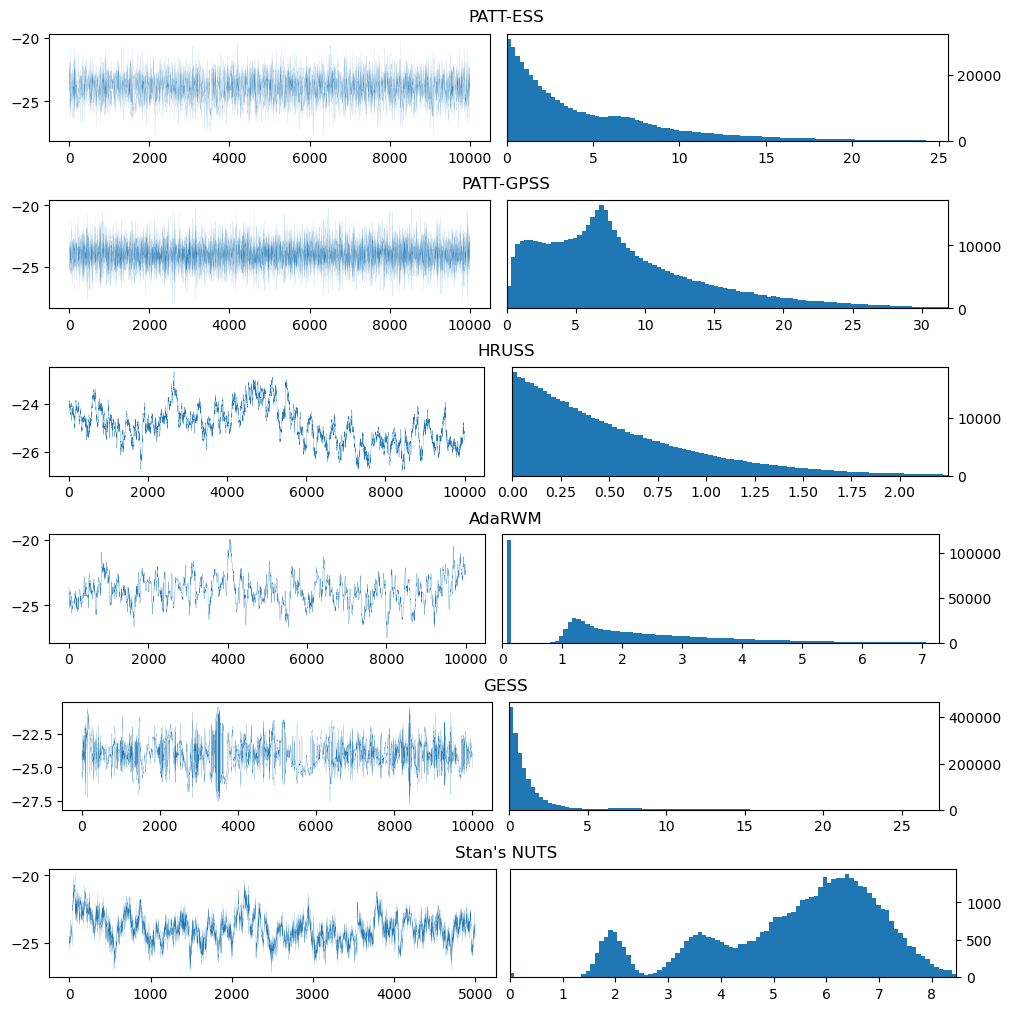

In [37]:
lws = [0.05, 0.05, 0.2, 0.2, 0.1, 0.1]
plot_steps = [np.copy(fs) for fs in flat_steps]
plot_steps[3] = plot_steps[3][plot_steps[3] != 0.0] # to make step histogram of AdaRWM actually plottable
pfs.plot_trace_and_step_hists(
    [sams[-n_win:,0,0] for sams in samples],
    plot_steps,
    snames,
    filepath = path_prefix + "traces_and_steps.png",
    lws=lws,
    nbins=100,
    same_range=False,
)

#### Additional Plots (and text outputs where plots are infeasible) 

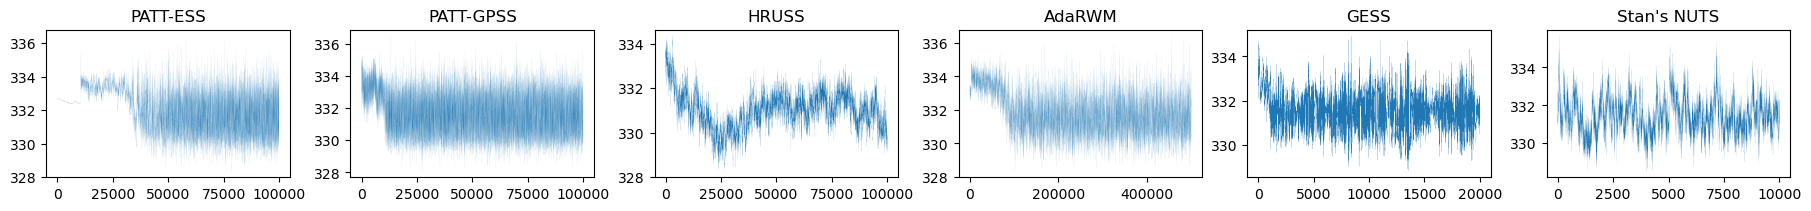

In [38]:
lws = [0.025, 0.025, 0.05, 0.025, 0.1, 0.05]
pfs.trace_plot_row([frs[:,0] for frs in full_radii], snames, lws=lws)

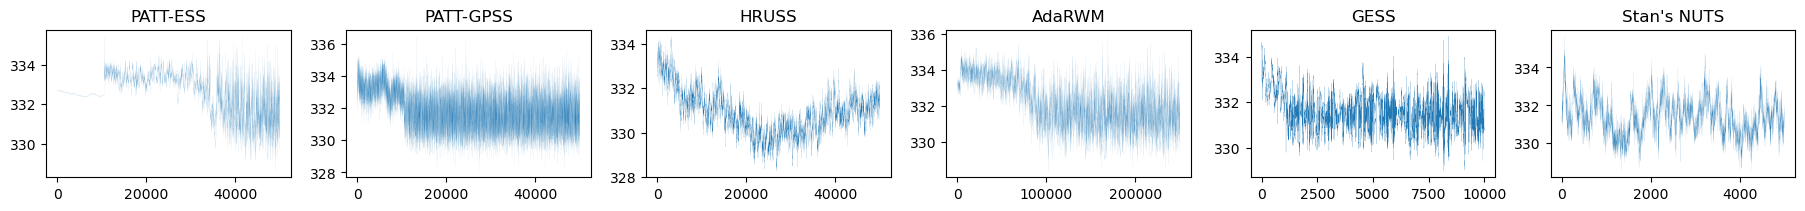

In [39]:
pfs.trace_plot_row([brs[:,0] for brs in burn_radii], snames, lws=lws)

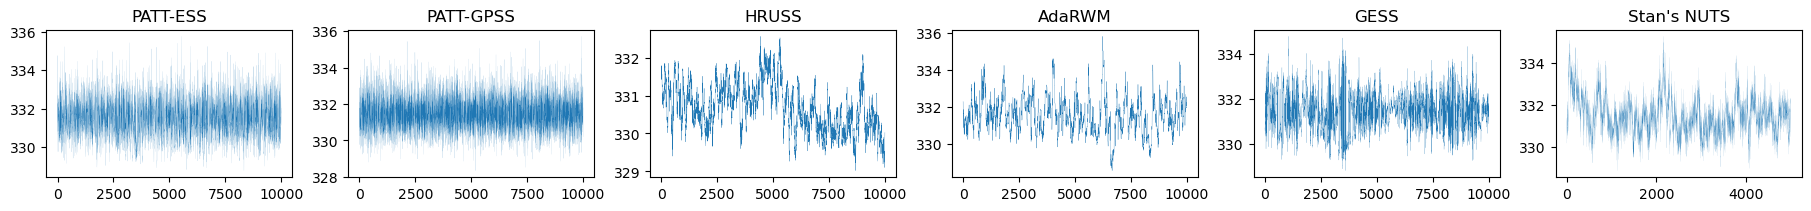

In [40]:
lws = [0.05, 0.05, 0.2, 0.2, 0.1, 0.05]
pfs.trace_plot_row([rs[-n_win:,0] for rs in radii], snames, lws=lws)

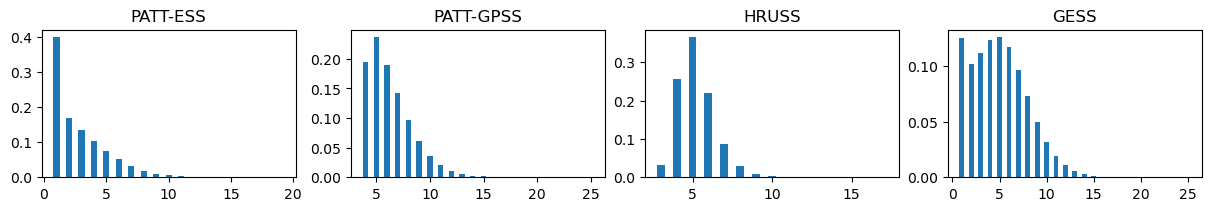

In [41]:
no_rwm = [0,1,2,4]
pfs.plot_tde_distr_row([tde[i] for i in no_rwm], [snames[i] for i in no_rwm])

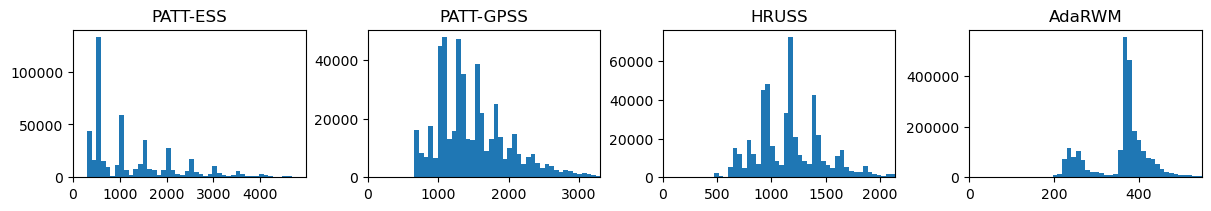

In [42]:
granular_times = [0,1,2,3]
pfs.plot_runtime_hist_row([times[i] for i in granular_times], [snames[i] for i in granular_times], cutoff_quant=0.99)

In [43]:
acc_rates_rwm = np.mean(ldv_rwm[n_its_rwm//2+1:] != ldv_rwm[n_its_rwm//2:-1], axis=0)
print("Average AdaRWM acceptance rate: {:.3f}".format(np.mean(acc_rates_rwm)))
print("Minimal AdaRWM acceptance rate: {:.3f}".format(np.min(acc_rates_rwm)))
print("Maximal AdaRWM acceptance rate: {:.3f}".format(np.max(acc_rates_rwm)))

Average AdaRWM acceptance rate: 0.267
Minimal AdaRWM acceptance rate: 0.264
Maximal AdaRWM acceptance rate: 0.271


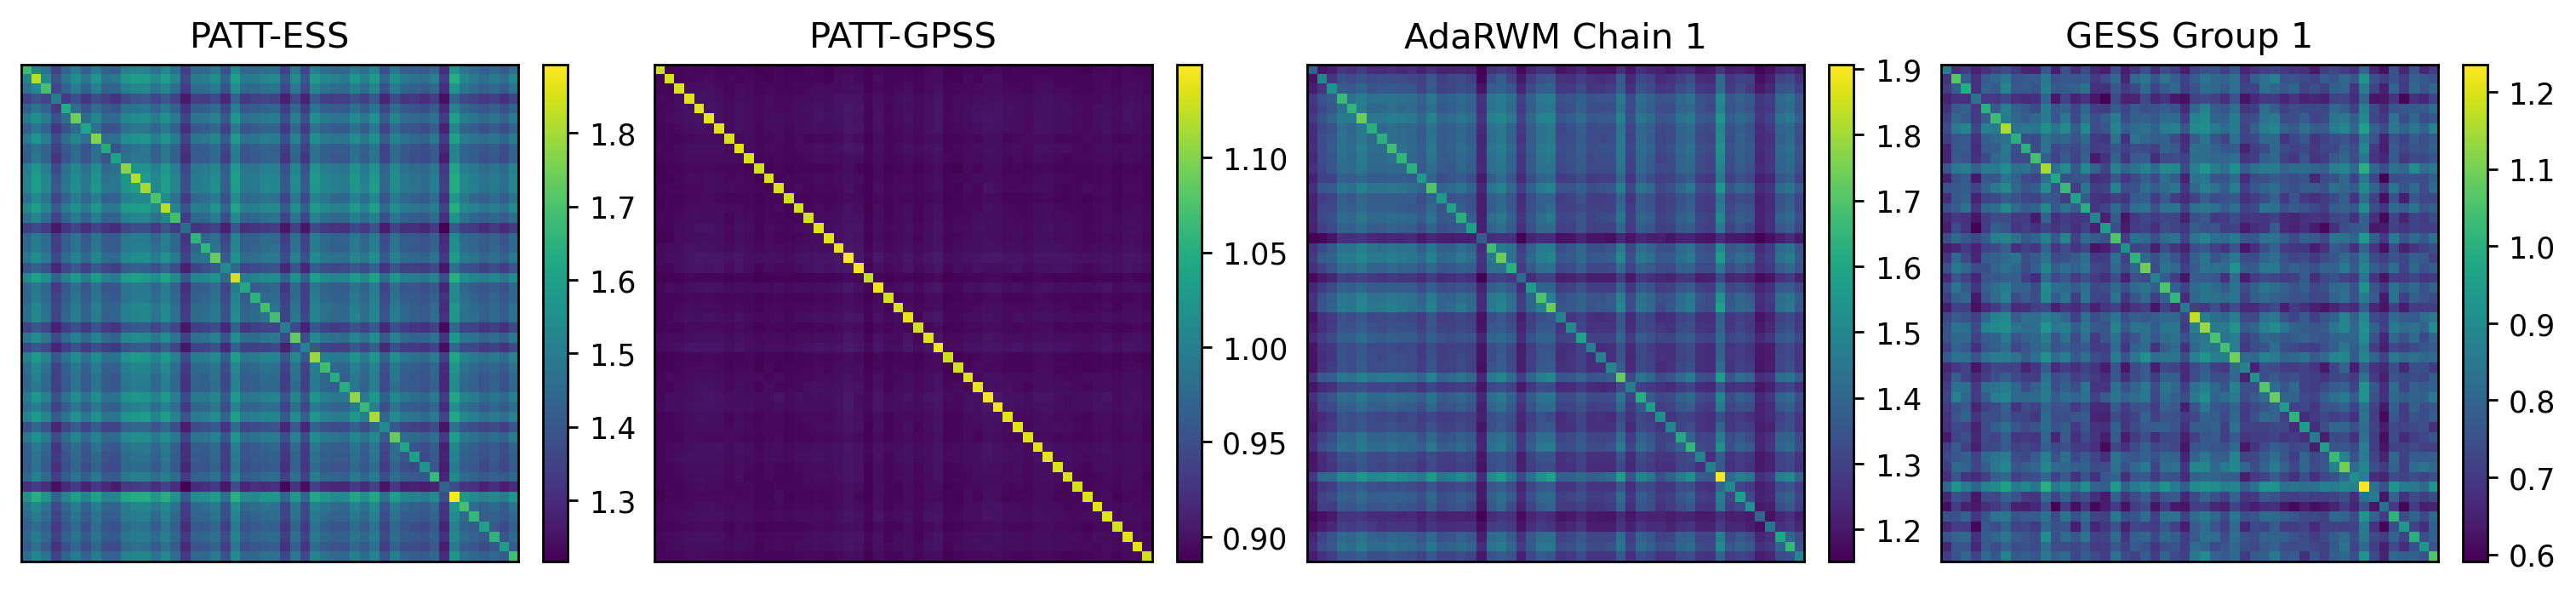

In [44]:
titles = ["PATT-ESS", "PATT-GPSS", "AdaRWM Chain 1", "GESS Group 1"]
covs = [covs_ess[-1], covs_gpss[-1], cov_rwm[0], scale_G1]
path = path_prefix + "covs.png"
pfs.plot_covs_row(covs, titles, filepath=path, shrink=0.8)

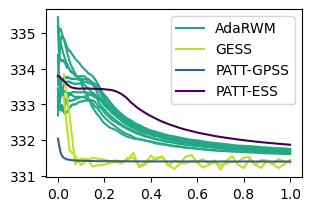

In [45]:
# plot progressions of the norm of each sampler's posterior mean approximation
norms_ess = mcu.get_radii(means_ess)
norms_gpss = mcu.get_radii(means_gpss)
norms_gess = mcu.get_radii(centers_gess)
colors = plt.cm.viridis(np.linspace(0, 0.9, 4))
pfs.initiate((3,2),100)
plt.plot(np.linspace(0,1,n_its_rwm+1), norms_rwm[:,0], color=colors[2], label=snames[3])
for i in range(1,n_chains):
    plt.plot(np.linspace(0,1,n_its_rwm+1), norms_rwm[:,i], color=colors[2])
plt.plot(schedule_gess[1:] / schedule_gess[-1], norms_gess[1:,0], color=colors[3], label=snames[4])
plt.plot(schedule_gess[1:] / schedule_gess[-1], norms_gess[1:,1], color=colors[3])
plt.plot(schedule_gpss / schedule_gpss[-1], norms_gpss, color=colors[1], label=snames[1])
plt.plot(schedule_ess / schedule_ess[-1], norms_ess, color=colors[0], label=snames[0])
plt.legend(loc='upper right')
pfs.wrapup()

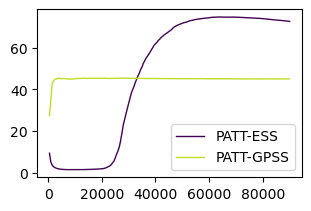

In [46]:
# plot progressions of the norm of the PATT samplers' posterior covariance approximations
cov_norms_ess = mcu.get_radii(covs_ess.reshape(schedule_ess.shape[0],-1))
cov_norms_gpss = mcu.get_radii(covs_gpss.reshape(schedule_gpss.shape[0],-1))
colors = plt.cm.viridis(np.linspace(0, 0.9, 2))
pfs.initiate((3,2),100)
plt.plot(schedule_ess[1:], cov_norms_ess[1:], color=colors[0], linewidth=1)
plt.plot(schedule_gpss[1:], cov_norms_gpss[1:], color=colors[1], linewidth=1)
plt.legend(snames[:2])
pfs.wrapup()

In [47]:
# I would plot the dfs used by GESS, but...
print(np.unique(dfs_G1[1:]))
print(np.unique(dfs_G2[1:]))

[1000000.]
[1000000.]


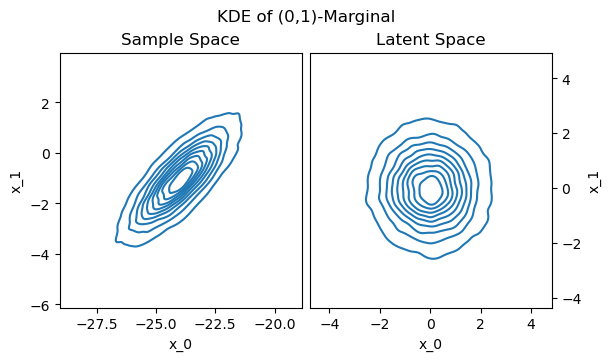

In [48]:
# plot a bivariate marginal KDE in sample space and (PATT-ESS's final) latent space
inds = [0,1]
ax_labels = ["x_{}".format(inds[0]), "x_{}".format(inds[1])]
fig, axes = plt.subplots(1,2, figsize=(6,3.5), dpi=100, constrained_layout=True)
fig.suptitle("KDE of ({},{})-Marginal".format(inds[0], inds[1]))
# left column: bivariate marginal in sample space
axes[0].set_title("Sample Space")
biv_sample_sp = np.concatenate([samples[0][:,0,inds[0]].reshape(-1,1),
                                samples[0][:,0,inds[1]].reshape(-1,1)], axis=1)
biv_sample_sp_frame = pd.DataFrame(biv_sample_sp, columns=ax_labels)
sb.kdeplot(biv_sample_sp_frame, x=ax_labels[0], y=ax_labels[1], ax = axes[0])
# right column: bivariate marginal in latent space
axes[1].set_title("Latent Space")
L = np.linalg.cholesky(covs_gpss[-1])
L_inv = np.linalg.inv(L)
alpha_inv = lambda y: L_inv @ (y - means_gpss[-1])
plot_latent_samples = np.apply_along_axis(alpha_inv, -1, samples[0][:,0])
biv_latent_sp = np.concatenate([plot_latent_samples[:,inds[0]].reshape(-1,1),
                                plot_latent_samples[:,inds[1]].reshape(-1,1)], axis=1)
biv_latent_sp_frame = pd.DataFrame(biv_latent_sp, columns=ax_labels)
sb.kdeplot(biv_latent_sp_frame, x=ax_labels[0], y=ax_labels[1], ax = axes[1])
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")
pfs.wrapup()

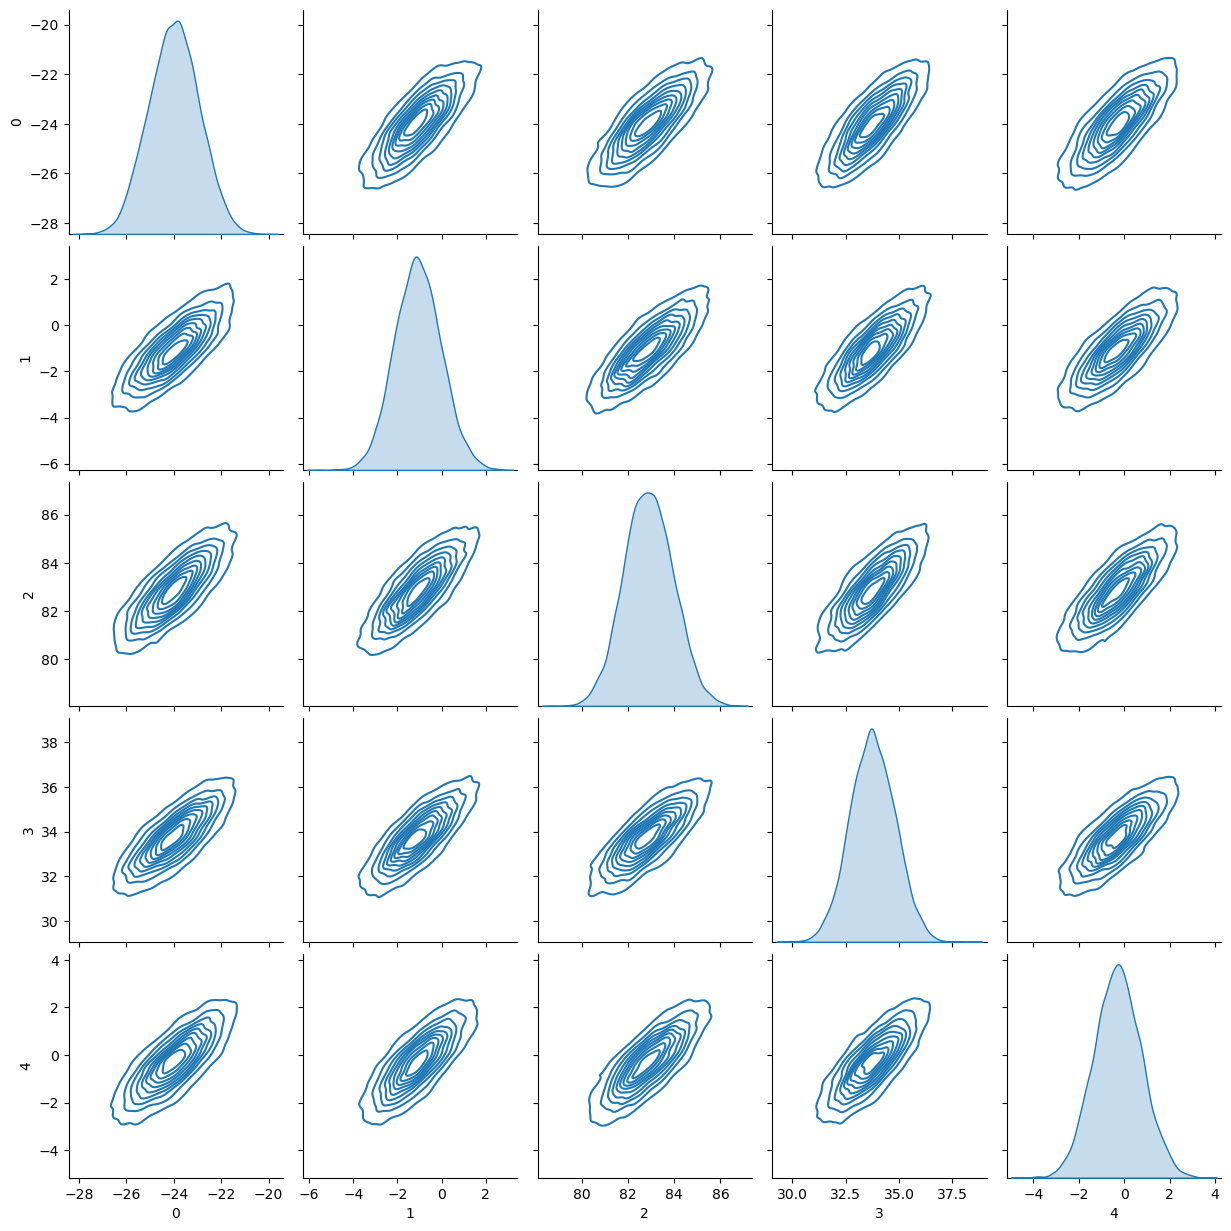

In [49]:
# this cell may take a few minutes to run
sb.pairplot(pd.DataFrame(samples[0][-n_win:,0,:5]), kind='kde')
plt.show()